In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

from preprocessing import split_data
from acquire import acquire_data
from prepare import prepare_data

import warnings
warnings.filterwarnings('ignore')

## Compare accuracy zillow_estimation vs baseline

In [2]:
df = prepare_data()
train, validate, test = split_data(df)
train.head()

,bathroomcnt,bedroomcnt,house_size,latitude,longitude,lotsize,regionidcity,regionidzip,actual_value,logerror,age,tax_rate,estimated,LA,Orange,Ventura
39903,2.0,4.0,1498.0,33991186.0,-117827282.0,8032.0,24384,96505,312264.0,-0.023107,46.0,1.218741,296084.211495,1,0,0
25501,2.5,3.0,1729.0,33584421.0,-117644775.0,5400.0,12773,96996,479202.0,0.017473,25.0,1.007404,498874.336287,0,1,0
22151,3.0,4.0,2824.0,34261050.0,-118567605.0,17507.0,12447,96346,552275.0,0.028148,49.0,1.253571,589255.063927,1,0,0
21858,2.0,4.0,1464.0,34268048.0,-118679847.0,5400.0,27110,97116,190998.0,0.030073,46.0,1.267217,204692.353491,0,0,1
8498,2.0,3.0,1648.0,33719549.0,-117816405.0,6000.0,27491,97016,273462.0,-0.003746,49.0,1.239426,271113.476791,0,1,0


In [3]:
# zillow_estimation evaluation
MSE = mean_squared_error(train.actual_value, train.estimated)
RMSE_estimate = np.sqrt(MSE)
RMSE_estimate

77695.66288586396

In [4]:
# baseline model evluation
train['baseline']=train.actual_value.mean()

MSE_baseline = mean_squared_error(train.actual_value, train.baseline)
RMSE_baseline = np.sqrt(MSE_baseline)
RMSE_baseline

315660.71230442636

## Apply clustering algrithm with logerror and create linear model

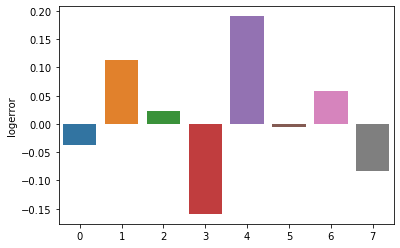

In [5]:
k =8
X = train[['logerror']]
kmeans = KMeans(k)
kmeans.fit(X)
center = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
sns.barplot(x = center.index, y = center.logerror)

In [6]:
train['cluster'] = kmeans.predict(train[['logerror']])
cluster_df = pd.get_dummies(train.cluster)
cluster_df.columns = ['a', 'b', 'c','d','e','f','g','h']
# concatenate the dataframe with the 3 county columns to the original dataframe
train= pd.concat([train, cluster_df], axis =1)
# drop regionidcounty and fips columns
train = train.drop(columns = ['cluster'])
train.head()

,bathroomcnt,bedroomcnt,house_size,latitude,longitude,lotsize,regionidcity,regionidzip,actual_value,logerror,...,Ventura,baseline,a,b,c,d,e,f,g,h
39903,2.0,4.0,1498.0,33991186.0,-117827282.0,8032.0,24384,96505,312264.0,-0.023107,...,0,431764.725078,1,0,0,0,0,0,0,0
25501,2.5,3.0,1729.0,33584421.0,-117644775.0,5400.0,12773,96996,479202.0,0.017473,...,0,431764.725078,0,0,1,0,0,0,0,0
22151,3.0,4.0,2824.0,34261050.0,-118567605.0,17507.0,12447,96346,552275.0,0.028148,...,0,431764.725078,0,0,1,0,0,0,0,0
21858,2.0,4.0,1464.0,34268048.0,-118679847.0,5400.0,27110,97116,190998.0,0.030073,...,1,431764.725078,0,0,1,0,0,0,0,0
8498,2.0,3.0,1648.0,33719549.0,-117816405.0,6000.0,27491,97016,273462.0,-0.003746,...,0,431764.725078,0,0,0,0,0,1,0,0


### build model predict estimation

In [7]:
X =['bathroomcnt', 'bedroomcnt', 'house_size', 'latitude', 'longitude',
    'lotsize', 'age', 'tax_rate','LA', 'Orange', 'Ventura',
    'a', 'b', 'c','d','e','f','g','h']
Y =['actual_value']

In [8]:
# Initialize the Linear Regression Object 
lm = LinearRegression()

rfe = RFE(lm, 9)

# Transforming data using RFE
X_rfe = rfe.fit_transform(train[X],train[Y])  
mask = rfe.support_

# select the column names of the features that were selected and convert them to a list for future use. 
rfe_features = train[X].columns[mask]
rfe_features

Index(['bathroomcnt', 'bedroomcnt', 'tax_rate', 'LA', 'Orange', 'Ventura', 'b',
       'd', 'e'],
      dtype='object')

In [9]:
lm = LinearRegression()
lm.fit(X_rfe,train[Y])
train['prediction'] = lm.predict(X_rfe)

RMSE_lm = np.sqrt(mean_squared_error(train.actual_value, train.prediction))

In [10]:
RMSE_lm, RMSE_estimate, RMSE_baseline

(253247.95242009521, 77695.66288586396, 315660.71230442636)

## Apply clustering algrithm with estimated and create linear model

In [11]:
df = prepare_data()
train, validate, test = split_data(df)

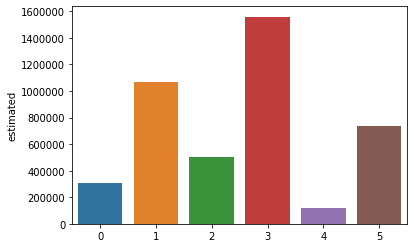

In [12]:
k =6
X = train[['estimated']]
kmeans = KMeans(k)
kmeans.fit(X)
center = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
sns.barplot(x = center.index, y = center.estimated)

In [13]:
train['cluster'] = kmeans.predict(train[['estimated']])
cluster_df = pd.get_dummies(train.cluster)
cluster_df.columns = ['a', 'b', 'c','d','e','f']
# concatenate the dataframe with the 3 county columns to the original dataframe
train= pd.concat([train, cluster_df], axis =1)
# drop regionidcounty and fips columns
train = train.drop(columns = ['cluster'])
train.head()

,bathroomcnt,bedroomcnt,house_size,latitude,longitude,lotsize,regionidcity,regionidzip,actual_value,logerror,...,estimated,LA,Orange,Ventura,a,b,c,d,e,f
39903,2.0,4.0,1498.0,33991186.0,-117827282.0,8032.0,24384,96505,312264.0,-0.023107,...,296084.211495,1,0,0,1,0,0,0,0,0
25501,2.5,3.0,1729.0,33584421.0,-117644775.0,5400.0,12773,96996,479202.0,0.017473,...,498874.336287,0,1,0,0,0,1,0,0,0
22151,3.0,4.0,2824.0,34261050.0,-118567605.0,17507.0,12447,96346,552275.0,0.028148,...,589255.063927,1,0,0,0,0,1,0,0,0
21858,2.0,4.0,1464.0,34268048.0,-118679847.0,5400.0,27110,97116,190998.0,0.030073,...,204692.353491,0,0,1,0,0,0,0,1,0
8498,2.0,3.0,1648.0,33719549.0,-117816405.0,6000.0,27491,97016,273462.0,-0.003746,...,271113.476791,0,1,0,1,0,0,0,0,0


### build model predict estimation

In [14]:
X =['bathroomcnt', 'bedroomcnt', 'house_size', 'latitude', 'longitude',
    'lotsize', 'age', 'tax_rate','LA', 'Orange', 'Ventura',
    'a', 'b', 'c','d','e','f']
Y =['actual_value']

# Initialize the Linear Regression Object 
lm = LinearRegression()

rfe = RFE(lm, 9)

# Transforming data using RFE
X_rfe = rfe.fit_transform(train[X],train[Y])  
mask = rfe.support_

# select the column names of the features that were selected and convert them to a list for future use. 
rfe_features = train[X].columns[mask]
rfe_features

Index(['bathroomcnt', 'tax_rate', 'LA', 'a', 'b', 'c', 'd', 'e', 'f'], dtype='object')

In [15]:
lm = LinearRegression()
lm.fit(X_rfe,train[Y])
train['prediction'] = lm.predict(X_rfe)

RMSE_lm = np.sqrt(mean_squared_error(train.actual_value, train.prediction))
RMSE_lm, RMSE_estimate, RMSE_baseline

(95272.95782632664, 77695.66288586396, 315660.71230442636)

### Key takeaways
***When apply clustering algrithom to estimated instead of logerror, It increase the accurcy of the prediction by a lot***

## Apply model to the test data

In [17]:
test['cluster'] = kmeans.predict(test[['estimated']])
cluster_df = pd.get_dummies(test.cluster)
cluster_df.columns = ['a', 'b', 'c','d','e','f']
# concatenate the dataframe with the 3 county columns to the original dataframe
test= pd.concat([test, cluster_df], axis =1)
# drop regionidcounty and fips columns
test = test.drop(columns = ['cluster'])
test.head()

,bathroomcnt,bedroomcnt,house_size,latitude,longitude,lotsize,regionidcity,regionidzip,actual_value,logerror,...,estimated,LA,Orange,Ventura,a,b,c,d,e,f
14954,1.0,2.0,966.0,33637948.0,-117875743.0,1003.0,53571,96978,350142.0,-0.014758,...,338443.557928,0,1,0,1,0,0,0,0,0
45439,3.0,4.0,2262.0,34503321.0,-118621756.0,6323.0,10734,96398,489081.0,0.001984,...,491320.558051,1,0,0,0,0,1,0,0,0
15949,1.0,2.0,784.0,34091001.0,-118107210.0,7500.0,33837,96515,446710.0,-0.072468,...,378056.936963,1,0,0,1,0,0,0,0,0
41016,1.0,3.0,1294.0,33817374.0,-118105742.0,5810.0,46298,96242,73675.0,0.061420,...,84867.314250,1,0,0,0,0,0,0,1,0
17094,2.0,3.0,1731.0,34209327.0,-118560580.0,6899.0,12447,96364,248800.0,0.014664,...,257344.111778,1,0,0,1,0,0,0,0,0


In [18]:
X = ['bathroomcnt', 'bedroomcnt', 'tax_rate', 'LA', 'Ventura', 'a', 'b', 'c','d','e','f']

In [20]:
test['prediction'] = lm.predict(test[['bathroomcnt', 'tax_rate', 'LA', 'a', 'b', 'c', 'd', 'e', 'f']])

RMSE_lm = np.sqrt(mean_squared_error(test.estimated, test.prediction))

RMSE_lm

72000.5862712991

In [ ]:
logerror = log(zillow_estimated) - log(acutal_value)
        = log(zillow_estimated/ actual_value)

In [ ]:
Le =log(ze/av)

In [ ]:
10^le = ze/av

In [ ]:
av * 10^le= ze

In [ ]:
ax1+ bx2+ ......= actual_value* 10^logerror= zillow_estimated

In [ ]:
ax1+ bx2+ ..... = logerror

3 models: 
    1. cluster with logerr
    2. cluster with estimate
    3. cluster with the independetn variable(square footage)
    4. cluster with one more independent variable(long lati)
    
target rmse prdciton value to acutal
    